In [87]:
#This mounts the google drive to the Colab VM
from google.colab import drive

drive.mount('/content/drive')

#This is the name of the folder where the ipynb file
FOLDERNAME = 'CVDL/project'

#Here, we're adding the folder to the path
import sys

sys.path.append("/content/drive/My Drive/{}".format(FOLDERNAME))

ModuleNotFoundError: No module named 'google.colab'

# Introduction and Objective

In this project, we will use an ML model used to detect emotions from static images and adapt it to analyze, in both, real-time and offline, video streams.

<img src="https://www.incimages.com/uploaded_files/image/1920x1080/getty_511992708_2000200020009280684_374718.jpg"/>

# Model Description

For our transfer learning application, we will be using the model provided by Ping Jian, Bo Wan, Quan Wang, and Jiang Wu in their paper entitled *"Fast and Efficient Facial Expression Recognition Using a Gabor Convolutional Network"*.

The link for the paper can be found [here](https://ieeexplore.ieee.org/document/9226082).

For an introduction to the model and analysis of the original code and its limitations, refer to the following notebook in this [link](https://colab.research.google.com/drive/1CwAA2k5lodCk24oa6DgvUPbLr9To4Lxk#scrollTo=l6k7yGiipxAJ).

<u>**NB:**</u> The content in this section *(Model Description)* is derived from the paper. We are just providing a brief overview of the paper and the model used; the work is not ours


## Architecture

The model is built to classify faces into **7 different emotional states**:
1. Anger
2. Disgust
3. Fear
4. Happy
5. Neutral
6. Sadness
7. Surprise


To achieve the aforementioned functionality, the model uses the following architecture:
![Model Pipeline](./images/model_pipeline.jpg)

Most notably, the model includes *Gabor Convolution* layers.
A detailed explanation can be found in the originally published paper *GaborNet: Gabor filters with learnable parameters in deep convolutional neural networks* via this [link](https://arxiv.org/ftp/arxiv/papers/1904/1904.13204.pdf#:~:text=Gabor%20Layer%20is%20a%20convolutional,by%20the%20standard%20backpropagation%20algorithm.).



As described in their paper, the model **takes in a 100x100 image**, crops it to 90x90, and then normalizes it by dividing the pixels by 255. 

Next, an Extend layer is used to extend the input by one dimension in order to accomodate for the gabor convolutional layers.

Afterwards, a series of Gabor Convolutional layers are used, where each one consists of the convolution itself, a batch normalization layer, a ReLU activation, and a max pooling layer.

Following the series of convolution, a Max layer is used to decrease the dimensionality of the convolution outputs; the result is then flattened and fed to two fully connected layers to yield the final prediction.

## Training and Testing

Several versions of the model were built, with different versions having different parameters for the Gabor Convolution (e.g., different dimensions, additional layers...)

Training was done on several databases, including the FER2013, the FERPlus, and the RAF databases.

The final models were tested on the RAF database. The results of the different models can be seen below:

![Models' performance](./images/models_performance.jpg)

We can see that the **GCN4_30** model yielded the best result with **87.21% accuracy**

The authors of the paper also included a comparison with different, well-known models:

![Comparison with other models](./images/comparison.jpg)

# Applying the Model on Saved and Real-Time Videos

## Haar Cascades and Face Detection

As discussed above, the model takes in a picture of a face. Therefore, when analyzing a video, whether real-time or offline, we will have to crop the faces and send the cropped version to the model; we will not send the raw data as is.

As such, the first step is to be able to identify where the faces are located. To do so, we will use the Haar Cascades available in OpenCV. The reason for this is the simplicity of the Haar Cascades and their easy implementation using OpenCV. After all, face detection can be a project by itself, where advanced ML models (e.g., deep learners) can be used and trained to detect faces. However, as the objective of this project is to detect emotions, and the face-detection is used as a simple pre-processing step to match the input of the DL model used, we will adopt a simple face-detection algorithm.

Enter **Haar classifiers** (presented by Paul Viola and Michael Jones), classifiers that were used in the first real-time face detector. A Haar classifier, or a Haar cascade classifier, is a machine learning object detection program that identifies objects in an image and video.


The algorithm can be explained in four stages:
<li>Calculating Haar Features</li>
<li>Creating Integral Images</li>
<li>Using Adaboost</li>
<li>Implementing Cascading Classifiers</li>





### Calculating Haar Features

A Haar feature is essentially calculations that are performed on adjacent rectangular regions at a specific location in a detection window. The calculation involves summing the pixel intensities in each region and calculating the differences between the sums. Here are some examples of Haar features below.

|<img src="https://miro.medium.com/max/828/1*yl-BqUzycbyfhPAzwWOddQ.webp" width="300" height="300"/> | <img src="https://miro.medium.com/max/1400/1*gl4JHntNPHQt1G7txpiRMA.webp" width="500" height="300"/>|
|-|-|

### Creating Integral Images

Since such features can be difficult to calculate for a large image, integral images can be used because the number of operations are greatly reduced.

Instead of computing at every pixel, integral images create sub-rectangles and array references for each one of these sub-rectangles. These rectangles are then used to compute the Haar features.

Below is an example of how an integral image works
<img src="https://miro.medium.com/max/1100/1*dy_lV_6Ne8KSeOWoWB1kAw.webp"/>

But, an issue still arises, as we don't care about all the features in an image. Naturally, we only care about the features of the objects -in our case, faces- that we want to detect.

To be able to determine the important features, an algorithm called Adaboost -Adaptive Boosting- is used.

### Adaboost Training

Adaboost training consists of using a combination of weak and strong classifiers to be able to successfully detect object.

* A weak classifier is basically a binary classification model that is said to perform slightly better than random guessing. In other words, classifiers that achieve slightly > 50% accuracy.

* A strong classifier, on the other hand, is a classification model that performs much better than random guessing.

What Adaboost does is combine several weak models to *boost* their performance, thus making the overall model a strong one. This technique is usually done because weak learners are easy to develop, while strong learners are harder to develop and understand.

Specifically, Adaboost's weak learners are created by moving a window over the input image, and computing Haar features for each subsection of the image. This difference is compared to a learned threshold that separates non-objects from objects. Because these are “weak classifiers,” a large number of Haar features is needed for accuracy to form a strong classifier.

<img src="https://miro.medium.com/max/1400/1*8cADlNiEJa5RAu4LqY4dgA.webp"/>

The last step thus consists of combining these models

### Cascading Classifiers

As was discussed above, we need to cascade the different weak learners to boost the entire model into a strong learner.

For a more detailed look into the Haar Classifiers, a link for the paper where it was introduced by Paul Viola and Michael Jones can be found
[here](https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf).

## Implementing Cascades in Python

Haar cascades can be implemented very easily in Python, as they come built in a module called OpenCV.

In this project, we will need to classify objects as either faces or not, to be able to crop the faces out of the full picture and feed them to our model. Thus, the Haar Classifiers we will use need to be trained in order to detect faces.

Fortunately, the OpenCV developers have already pre-trained classifiers for different purposes. Files that contain the trained 'weights' can be downloaded through [their github repository](https://github.com/opencv/opencv/tree/master/data/haarcascades).

In our case, we download the ***frontal face* package** and use it to create the classifier, as seen below.

In [1]:
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from net_factory import GCN_mod
import numpy as np
from PIL import Image
import time

In [2]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

However, the cascade classifier works on grayscale images. As such, we first load the image, then convert it to grayscale.

In [3]:
img = cv2.imread("./Inputs/test.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

The function used to detect the faces is *detectMultiScale*. According to the [documentation](https://docs.opencv.org/3.4/d1/de5/classcv_1_1CascadeClassifier.html#aaf8181cb63968136476ec4204ffca498), the function takes in several parameters, two of which are of importance:

1. **scaleFactor**: Parameter that **specifies how much the image size is reduced at each image scale**. This is used in the computation of the features. Details of the importance of this factor can be found [here](https://sites.google.com/site/5kk73gpu2012/assignment/viola-jones-face-detection#TOC-Image-Pyramid), but generally speaking, the smaller the value, the slower the algorithm, but the more thorough it is as it would detect faces of different sizes, and as such, different distances from the camera.

2. **minNeighbors**: Parameter that **specifies how many neighbors each candidate should have** to be retained. This parameter will affect the quality of detected faces; thus, higher values result in less detections but with higher quality.

We will adopt a **scale factor of 1.3** and a **minNeighbors of 3**, as after some testing, we found that these provide a good balance between quality and speed, specially for the real-time analysis of the video 

In [4]:
faces = face_cascade.detectMultiScale(gray, 1.3, 4)

At this point, we would have gotten the rectangular coordinates that surround the faces in an image. We move on to plot the rectangles

In [5]:
temp = img.copy()
for (x, y, w, h) in faces:
    cv2.rectangle(temp, (x, y), (x + w, y + h), (255, 0, 0), 10)

Let's look at the output. Note that OpenCV reads the image as BGR, while the plotting tools reads the image as RGB. Thus, we need to convert the image first to RGB.

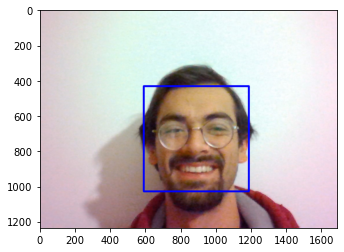

In [6]:
#Convert image to RGB
temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)

plt.imshow(temp)
plt.show()

Next, we crop the image to extract the face by itself. To do so, we use the coordinates used for the rectangle

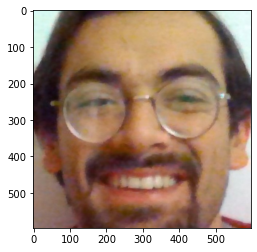

In [7]:
cropped = img[y:y + h, x:x + h]
cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)

plt.imshow(cropped)
plt.show()

This image would be the one fed to the model.

## Initializing the Model

### Loading the Model

Next, we define a function to load the pre-trained model

In [9]:
def load_model(model_name):
    """
    Loads the pre-trained model along with its weights.

    Parameters
    ----------
    model_name : String
        The name of the pre-trained model file.

    Returns
    -------
    model : Object
        Pytorch object of the loaded model

    """

    model = GCN_mod(channel=4, lych=10)
    model.load_state_dict(
        torch.load(model_name, map_location=torch.device('cpu')))
    model.eval()

    return model

### Testing the Model

Now, we load the model and test it on some of the authors' inputs.

First, we define a function that gets the prediction from a model and does the  necessary transforms for the input.

In [10]:
def get_prediction(model, img):
    """
    Applies an image through a model pipeline. Input image is resized to 100x100, converted to grayscale,
    then fed to the model. Prediction of the emotion is returned.

    Parameters
    ----------
    model : Object
        A loaded Pytorch model.
    img : PIL Image
        The image that the model is to process.

    Returns
    -------
    String
        The model's prediction (one of 7 classes of emotions). 

    """

    #Preprocess the cropped image. This is model-specific
    transform = transforms.Compose([
        transforms.Grayscale(1),
        transforms.Resize(size=(100, 100)),
        transforms.TenCrop(90),
        transforms.Lambda(lambda crops: torch.stack(
            [transforms.ToTensor()(crop) for crop in crops])),
    ])

    #Apply transformations on the image
    timg = transform(img)

    #Forward pass to get prediction
    with torch.no_grad():
        score = model(timg)

    score = score.mean(dim=0)

    #Get the output emotion
    outs = [
        'Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise'
    ]
    emotion = torch.argmax(score)

    return outs[emotion.numpy()]

Now, let's instantiate the model and try out the prediction on 2 sample images (provided by the authors)

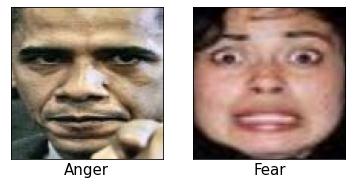

In [11]:
#Load the model
model = load_model('trained_RAF_10.pt')

#Array of test images
images = ["./Inputs/t1.jpg", "./Inputs/t2.jpg"]

#Plotting loop
plt.figure()
for i, im in enumerate(images):
    #Read the image
    img = cv2.imread(im)
    #Convert the color
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    
    #Convert ndarray to PIL for the model to process it
    img = Image.fromarray(np.uint8(img))
    
    #Get a prediction
    label = get_prediction(model, img)

    #Plot
    plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(label, fontsize=15)

## Extrapolating to Video

Now, we must extrapolate the use of the model to videos. 

To do so, we simply process the video frame by frame. Each time, we use the Haar Classifiers to locate the face. Then, we crop the face, and feed it to the model, which then comes back with a prediction.

This prediction, along with with the bounding box of the face, is added to the frame. At the end, when all frames are processed, they are saved in a new video file.


In [12]:
def face_in_vid(input_path, output_path, model):
    """
    Processes an input video file by detecting faces and their emotions, 
    and generates a new video file. In this file, faces are outlined with a box,
    and the emotion they portray is displayed above the box.

    Parameters
    ----------
    input_path : String
        A path that contains the video that needs to be processed.
    output_path : String
        The path where the resulting video should be in.
    model : Object
        A Pytorch model that will process the video.

    Returns
    -------
    Dictionary
        A dictionary that contains time data of the analysis. 'Overall' key corresponds to the total processing time, and
        'Frames' key corresponds to processing time of each and every frame.

    """
    
    #Read video
    video = cv2.VideoCapture(input_path)

    #Get video dimensions
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))
    size = (frame_width, frame_height)
    
    #Create output vide (AVI Codec)
    result = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'MJPG'), 10, size)
        
    #Load the cascade classifier
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    #Start recording time of entire pipeline
    overall_start = time.time()

    #List of elapsed time for frame-by-frame processing
    frame_dur = []
    
    while True:
        #Record time frame by frame
        frame_start = time.time()

        #Read the frame
        ret, img = video.read()

        #Condition to check if data is available
        if ret:
            # Convert image to grayscale for detecting faces
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Detect the faces
            faces = face_cascade.detectMultiScale(gray, 1.3, 3)

            # Draw the rectangle around each face labeled with the emotion
            for (x, y, w, h) in faces:
                #Crop the face by itself
                cropped = img[y:y + h, x:x + h]

                #Convert to PIL image for processing
                cropped_pil = Image.fromarray(np.uint8(cropped))

                #Get a prediction on the emotion
                label = get_prediction(model, cropped_pil)

                #Plot the bounding box
                cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

                #Write the prediction above the box
                cv2.putText(img,
                            text=label,
                            org=(x, y - h // 15),
                            fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                            fontScale=1,
                            color=(0, 255, 0),
                            thickness=2)

                
            #Append time taken for this frame to overall list
            frame_dur.append(time.time() - frame_start)
            
            #Output updated frame to video file
            result.write(img)

        else:
            break

    # Release the VideoCapture object
    video.release()
    result.release()

    #Build the history object that contains the time information
    hist = {"Overall": time.time() - overall_start, "Frames": frame_dur}

    return hist

Let's see how that works out:

In [13]:
#Run the model
model = load_model('trained_RAF_10.pt')
hist = face_in_vid("./Inputs/test_vid.mp4", "./Outputs/result.avi", model)

To be able to visualize the result, we will randomly select 9 frames from the video to display below

In [16]:
import random

#Read video
video = cv2.VideoCapture('./Outputs/result.avi')

#Get amount of frames and total length of video (length to be used later)
amount_of_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
fps = video.get(cv2.CAP_PROP_FPS)
total_vid_duration = amount_of_frames / fps

frames = []
for _ in range(9):
    #Set current frame to be read
    frame_number = random.randint(1, amount_of_frames)
    video.set(cv2.CAP_PROP_POS_FRAMES, frame_number - 1)

    #Read desired frame
    ret, frame = video.read()
    frames.append(frame)

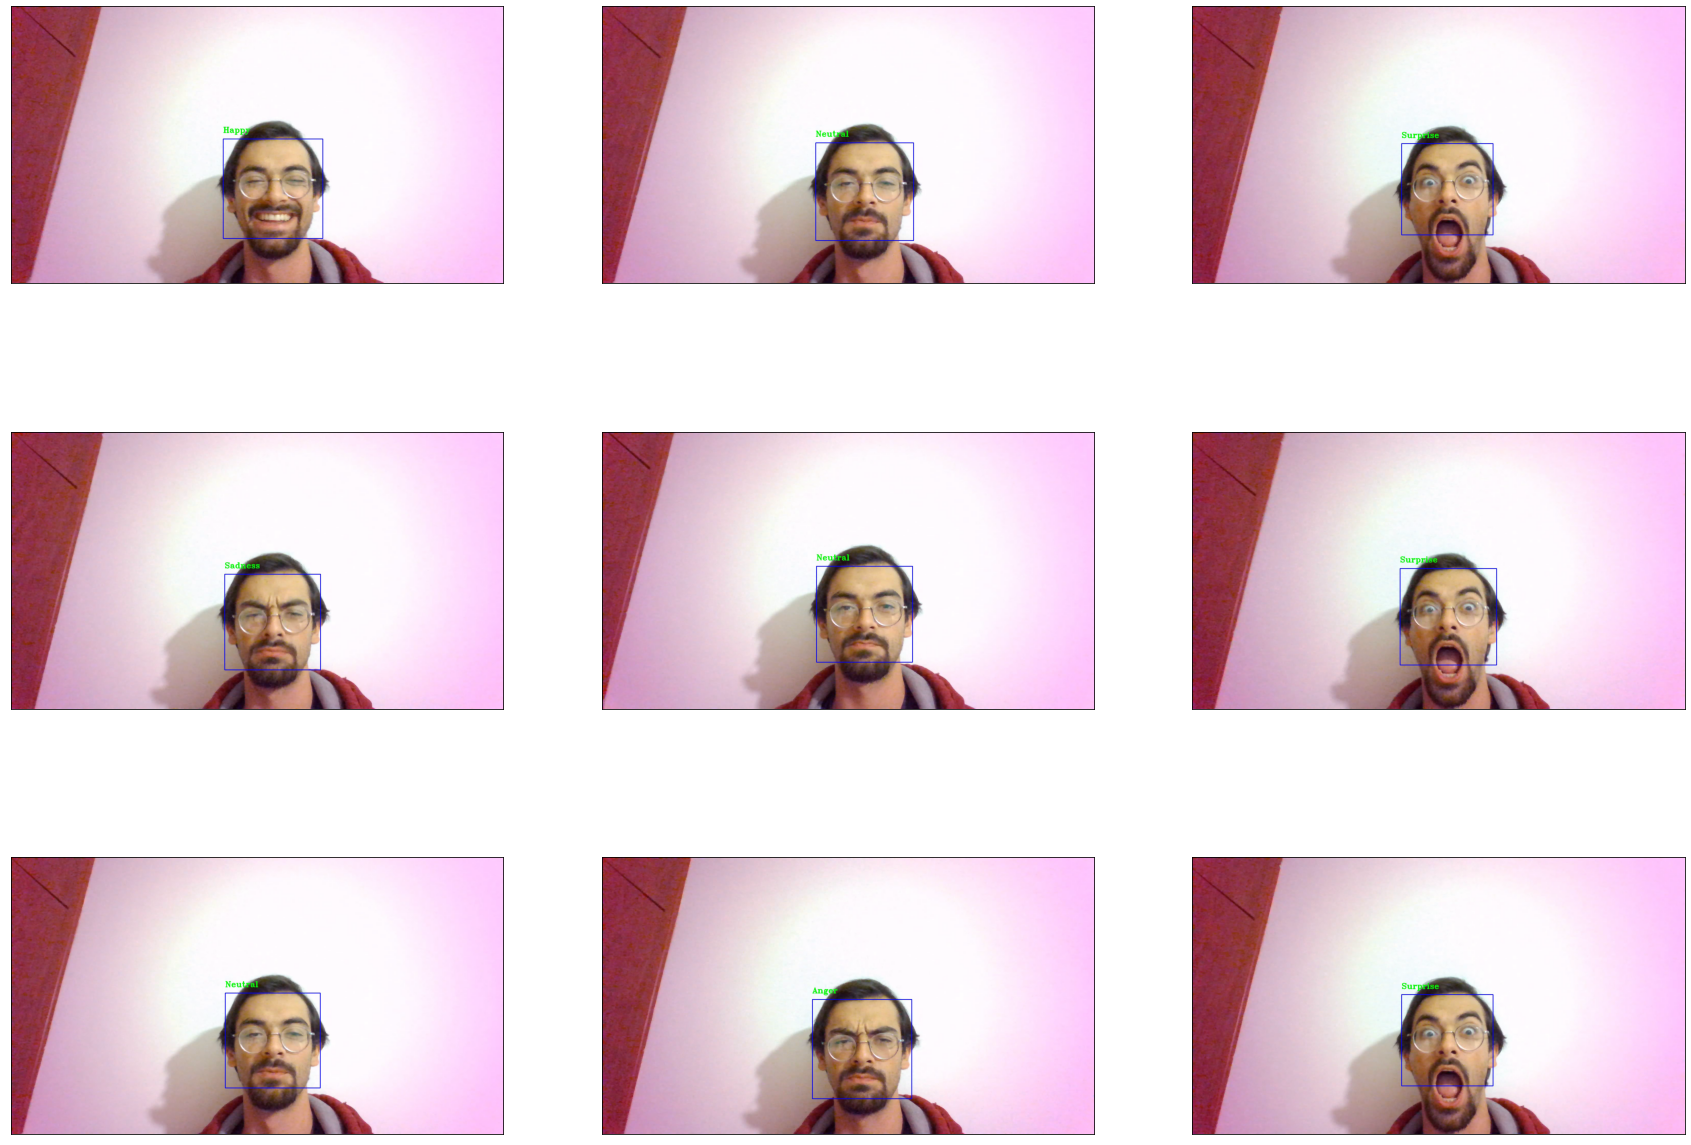

In [17]:
#Display frames
plt.figure(figsize=(30, 30))
for i, frame in enumerate(frames):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 3, i + 1)
    plt.imshow(frame)
    plt.xticks([])
    plt.yticks([])

video.release()

We can see how the output video file contains a bounding box for each face, as well as a prediction for the face's displayed emotion.

### Analyzing Prediction Time
Since the objective is to use such an algorithm on real-time video, we need to study the distribution of processing time to be able to determine if the results are adequate for real-time analysis.

Therefore, we will use the *history* object that the function defined above returns to generate some statistics about processing time.

In [18]:
total_processing_time = hist["Overall"]
frame_processing_time = hist["Frames"]

print(f"Total video length: {total_vid_duration:.2f}s\nTotal Processing Time: {total_processing_time:.2f}s")

Total video length: 20.00s
Total Processing Time: 64.63s


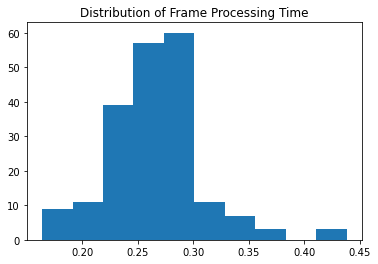

Average time taken per frame: 0.2648
Standard deviation: 0.0430
Median value: 0.2679


In [19]:
plt.figure()
plt.hist(frame_processing_time)
plt.title("Distribution of Frame Processing Time")
plt.show()

print(f"Average time taken per frame: {np.mean(frame_processing_time):.4f}")
print(f"Standard deviation: {np.std(frame_processing_time):.4f}")
print(f"Median value: {np.median(frame_processing_time):.4f}")

We can see that, in general, this model has somwhat of a slow performance, as the model took **3x the length of the video** to produce an output.

Note that, however, processing time might vary greatly depending on the machine and the hardware being used. As such, these values are to be taken lightly. Even on the same machine, we saw a great difference in processing time.

As such, ideally, several hundreds of tests should be conducted, with processing time being recorded for each iteration. Then, these values would be plotted to create a sampling distribution, from which we can then analyze the processing time within a certain confidence interval. But, even in this case, the results would be dependent on the platform being used. 

Such an analysis was not conducted in this project due to time constraints.

### Plotting change of emotion throughout video

To visualize the change in happiness, we will have two main categories of graphs:

1. A graph for each emotion, where each graph shows the percentage (probability prediction of the model) of a certain emotion as a function of time

2. A graph that shows the dominant emotion as a function of time

However, to be able to achieve this, we must alter the model. 

Recall, the model has the following architecture:

<img src="./Images/model_pipeline.jpg" width="800" height="300"/>

We can see that it is **lacking a final softmax layer**, and as such, the **outputs cannot be interpreted as probabilities** and thus can't be used as described above to plot a *per emotion graph*

As such, **we will add a final softmax layer** in our *get_prediction* function

In [27]:
def get_prediction(model, img):
    """
    

    Parameters
    ----------
    model : TYPE
        DESCRIPTION.
    img : TYPE
        DESCRIPTION.

    Returns
    -------
    TYPE
        DESCRIPTION.

    """
    
    #Preprocess the cropped image. This is model-specific
    transform = transforms.Compose([
        transforms.Grayscale(1),  
        transforms.Resize(size=(100,100)),
        transforms.TenCrop(90),  
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),    
        ])
    

    #Apply transformations on the image 
    timg = transform(img)

    #Forward pass to get prediction
    with torch.no_grad():
        score = model(timg)
        
    
    score = score.mean(dim=0)
    #Additional Softmax Layer
    layer = torch.nn.Softmax(0)
    probabilities = layer(score)

    
    
    #Get the output emotion
    outs = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
    emotion = torch.argmax(probabilities)
    
    return outs[emotion.numpy()], probabilities

## Real-time Analysis Function

Now, we create a new function to conduct the real-time analysis. It is mostly behaves the same as the previous face_vid function

In [28]:
def real_time_analysis(model):
    video = cv2.VideoCapture(0)
    
    # Load the cascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    outs = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
    prediction_values = {x: [] for x in outs}
    time_values = []
    
    #Get FPS
    FPS = int(video.get(cv2.CAP_PROP_FPS))
        
    frame_nb = 0
    while True:
        #Read the frame
        ret, img = video.read()

        #Condition to check if frame is available
        if ret:
            frame_nb += 1
            #Flip image because camera input is flipped
            img = cv2.flip(img, 1)
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Detect the faces
            faces = face_cascade.detectMultiScale(gray, 1.5, 4)

            # Draw the rectangle around each face labeled with the emotion
            for (x, y, w, h) in faces:
                #Crop the face by itself
                cropped = img[y:y + h, x:x + h]

                #Convert to PIL image for processing
                cropped_pil = Image.fromarray(np.uint8(cropped))

                #Get a prediction on the emotion
                label, probabilities = get_prediction(model, cropped_pil)

                for pos, proba in enumerate(probabilities):
                    prediction_values[outs[pos]].append(proba)
                time_values.append(frame_nb / FPS)

                #Plot the bounding box
                cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

                #Write the prediction on the box
                cv2.putText(img,
                            text=label,
                            org=(x, y - h // 15),
                            fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                            fontScale=1,
                            color=(0, 255, 0),
                            thickness=2)
                
                
            # Display the resulting frame
            cv2.imshow('frame', img)
              
            # the 'q' button is set as the
            # quitting button you may use any
            # desired button of your choice
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        else:
            break

    # Release the VideoCapture object
    video.release()
    cv2.destroyAllWindows()

    return prediction_values, time_values

Due to the changes we made to the *get_prediction* function, we can plot the change of emotion throughout the video.

In [29]:
time_vs_emotion, time_values = real_time_analysis(model)

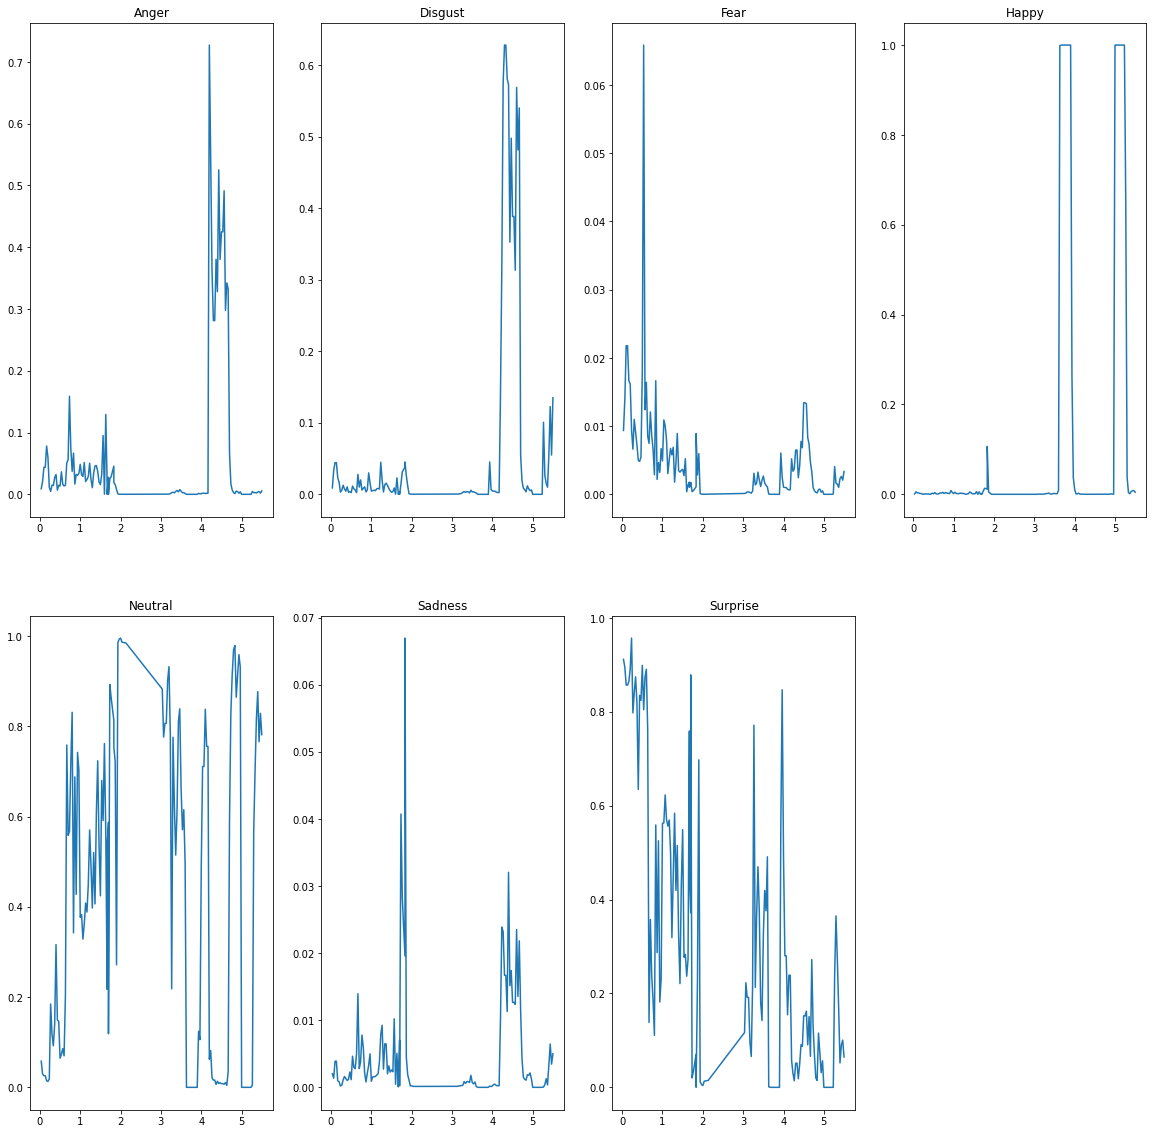

In [30]:
plt.figure(figsize=(20,20))
for i, emotion in enumerate(time_vs_emotion):
    plt.subplot(2,4, i+1)
    plt.plot(time_values, time_vs_emotion[emotion])
    plt.title(emotion)

We can see that the result is not very smooth, with some considerable fluctuations throughout.

To try and mitigate that, we will be introducing an improved method for video processing.

## Improved Method for Video Processing

There are two thresholds that must be taken into consideration for an application as ours:

1. Amount of **time required for a change in emotion** to become visible on a human face
2. Amount of **time it takes for the detection of the emotion** by the ML model

Since it is quite **unlikely** that there is a **drastic emotion change between a consecutive frames of a video**, we thought of implementing a *neighborhood* functionality to increase the model's robustness against changes/fluctuations in predictions.

Basically, to determine the emotion of a face in an image, **we will be looking not only at the current frame, but also at the neighboring frames** (the previous frame and the one after, to be exact). **We check the emotion of the face in the neighbors too, and we assign the label that was the most common in the neighborhood.**

To do so, we need to take **2 main things into considerations**:

1. Since we will be checking neighboring frames, the same computations will be conducted on the same frames more than once. As such, it is imperative to use some type of **memoization/dynamic programming** where we **store the previously-computed outputs** as not to waste time re-computing the same predictions. (E.g. where this applies: neighborhood [1, 2, 3] and [2,3,4] both have frame 2).


2. Since we are taking into account the possibility of having **>1 face per video**, we need to be able to **match faces together across different frames.** In our case, we will do so by **checking the positions fo the faces**: since it is unlikely that the faces will be translated by a great amound between frames (that is, in a difference of ~0.03s, assuming 27 fps), we can say that **two faces in two consecutive frames represent the same person** (and thus must have their predictions compared together) **if they did not change positions drastically between these two frames**. We will use a **threshold**, which was determined through trial and error, to determine what counts as a major shift or not.

Now that we have defined this improved method, we can start with its implementation.

First, let's refactor some of the code. We will create a new method, called *get_faces_and_prediction*.

In [36]:
from scipy import stats
import itertools

In [37]:
def get_faces_and_prediction(frame, model):
    """
    Returns a dictionary with the location and the label of each face in a frame

    Parameters
    ----------
    frame : PIL Image
        An image.

    model: Pytorch Model
        A model from which to predict the emotion of a face.

    Returns
    -------
    results : Dictionary
        Dictionary, where the keys are the coordinates of the faces, and the
        values are the label for each face.

    """
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Load the cascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Detect the faces
    faces = face_cascade.detectMultiScale(gray, 1.2, 3)

    results = {}
    # Draw the rectangle around each face labeled with the emotion
    for (x, y, w, h) in faces:
        # Crop the face by itself
        cropped = frame[y:y + h, x:x + h]

        # Convert to PIL image for processing
        cropped_pil = Image.fromarray(np.uint8(cropped))

        # Get a prediction on the emotion
        label, probabilities = get_prediction(model, cropped_pil)

        # Append label of current face to labels
        results[(x, y, w, h)] = label

    return results

Note that most of the code in this function was implemented in the *face_vid* function earlier; we are refactoring into this function for ease of use later on, and to have the ouput as a dictionary that contains the faces as keys and the labels as values.

Now let's create a function that gets the neighborhood of a certain frame, checks the most common emotions of different faces in this neighborhood, then assigns the most common emotions to the current frame.

In [38]:
def average_of_images(images, model, previous_images):
    """
    Predicts the emotion of faces in an image. This is done by checking the entire neighborhood (nb of neighbors = 3)
    and assigning for a face the emotion that occurred most in this neighborhood.

    Parameters
    ----------
    images : dictionary
        Dictionary where the keys are the frame number in the overall video, 
        and the values are the images themselves.
        NB: The objective of the model is to get the predictions of the middle
        frame.
    model : Pytorch Object
        Model with which to analyze the values.
    previous_images : dictionary
        Dictionary where the keys are the frame numbers of images previously 
        analyzed, and the values are other dictionaries with keys being 
        coordinates of face and values being labels for each face.
        

    Returns
    -------
    averaged_out : dictionary
        Dictionary where the keys are the coordinates of the faces in the image
        that is meant to be processed (the one in the middle of the neighborhood),
        and the values are the labels that occured the most for each face.

    """
    
    #Dictionary that will contain the neighboring frames and the labels of the faces in the frames
    overall = {}
    
    #Take every frame in the neighborhood
    for frame_number in images:
        #If this frame was processed before (i.e., present in the previous_images dic), add it directly
        if frame_number in previous_images:
            overall[frame_number] = previous_images[frame_number]
            
        #If not, run the frame through the model to get the faces and their predictions
        else:
            current_frame_image = images[frame_number]
            faces_and_preds = get_faces_and_prediction(current_frame_image, model)
            overall[frame_number] = faces_and_preds
            previous_images[frame_number] = faces_and_preds
            
    averaged_out = {}
    
    #Get target frame number. To do so, we get the median of the keys, which
        #correspond to the frame numbers. We can do so because the assumption 
        #is that neighborhood consists of an odd number of frames, in 
        #consecutive, increasing order (e.g., [1,2,3], [1,2,3,4,5])
    target_frame_number = int(np.median(list(overall.keys())))
    
    #Get the current faces
    current_keys = overall[target_frame_number].items()
    
    #Define threshold to check if same face
    DIFFERENCE_IN_THRESHOLD = 10
    
    #Remove the target frame from the overall object to process labels below
    overall.pop(target_frame_number)

    for img in overall.values():
        #Get list of possible combinations between faces of the main image and faces of the secondary image
        current_combs = list(itertools.product(current_keys, list(img.items())))
        
        #Check which faces of main correspond to the faces of the secondary
        #Unpack the current_combs into coordinates and labels of main and secondary
        for (main_coordinate, main_label), (secondary_coordinate, secondary_label) in current_combs:
            
            #Variable to keep track if the secondary should be accepted
            accepted = True
            
            #Take the dimensions of the two faces in pair to check if their difference falls within the threshold
            for main_dim, secondary_dim in zip(main_coordinate, secondary_coordinate):
                
                #Check if difference falls within threshold
                if np.abs(main_dim - secondary_dim) > DIFFERENCE_IN_THRESHOLD:
                    #If it does not, reject the current combination and disregard other dimensions
                    accepted = False
                    break
                    
            #If no dimensions were rejected, proceed to accept the combination
            if accepted:
                
                #If face already exists in overall result, just append the new label to the existing list of labels
                if main_coordinate in averaged_out:
                    averaged_out[main_coordinate].append(secondary_label)
                    
                #If face does not exist, create a new entry in the final result, where the values are the main label and the new label
                else:
                    averaged_out[main_coordinate] = [main_label, secondary_label]
    
    #Choose the prediction that appeared most in the neighborhood
    averaged_out_common = {k: str(stats.mode(v).mode[0]) for k, v in averaged_out.items() }
    return averaged_out_common

Now, we update *face_in_vid* to use the *average* instead of the traditional get_prediction

In [42]:
def face_in_vid(input_path, output_path, model):
    """
    Processes an input video file by detecting faces and their emotions, and generates a new video file with this analysis

    Parameters
    ----------
    input_path : String
        A path that contains the video that needs to be processed.
    output_path : String
        The path where the resulting video should be in.
    model : Object
        A Pytorch model that will process the video.

    Returns
    -------
    Dictionary
        A dictionary that contains time data of the analysis. 'Overall' key corresponds to the total processing time, and
        'Frames' key corresponds to processing time of each and every frame.

    """
    

    #Read video
    video = cv2.VideoCapture(input_path)

    #Get video dimensions
    frame_width = int(video.get(3))
    frame_height = int(video.get(4))
    size = (frame_width, frame_height)
    
    #Get number of frames in video
    FRAMES_IN_VIDEO = int(video.get(cv2.CAP_PROP_FRAME_COUNT)) - 1

    
    #Create output vide (AVI Codec)
    result = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'MJPG'), 10, size)
        
    #Start recording time of entire pipeline
    overall_start = time.time()

    #List of elapsed time for frame-by-frame processing
    frame_dur = []
    
    #Dictionary that contains the list of frames already processed
    images_processed = {}
    
    frame_nb = 0
    while frame_nb != FRAMES_IN_VIDEO:
        #Record time frame by frame
        frame_start = time.time()

        #Increment frame number
        frame_nb += 1
        
        frames_to_process = {}
        
        #Read the frame
        video.set(1, frame_nb)
        ret, img = video.read()
        frames_to_process[frame_nb] = img
        
        #If frame is not first frame, add the previous to the neighborhood
        if frame_nb != 1:
            video.set(1, frame_nb-1)
            ret_prev, frame_prev = video.read()
            frames_to_process[frame_nb-1] = frame_prev
        
        #If frame is not last frame, add the next frame to the neighborhood
        if frame_nb != FRAMES_IN_VIDEO:
            video.set(1, frame_nb+1)
            ret_next, frame_next = video.read()
            frames_to_process[frame_nb+1] = frame_next
            
        
        faces_and_preds = average_of_images(frames_to_process, model, images_processed)
        for (x,y,w,h), label in faces_and_preds.items():
            #Plot the bounding box
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

            #Write the prediction above box
            cv2.putText(img,
                        text=label,
                        org=(x, y - h // 15),
                        fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                        fontScale=1,
                        color=(0, 255, 0),
                        thickness=2)

            
        #Append time taken for this frame to overall list
        frame_dur.append(time.time() - frame_start)
        
        
        #Output updated frame to video file
        result.write(img)


    # Release the VideoCapture object
    video.release()
    result.release()

    #Build the history object that contains the time information
    hist = {"Overall": time.time() - overall_start, "Frames": frame_dur}

    return hist


We can now run the model to produce an updated result. 

Note that this updated method takes more processing time, due to the analysis of several frames for every needed frame.

In [43]:
#Run the model
model = load_model('trained_RAF_10.pt')
hist = face_in_vid("./Inputs/test_vid.mp4", "./Outputs/result_improved.avi", model)

We also provide an updated method for the real time analysis of the video

In [44]:
def real_time_analysis(model):
    video = cv2.VideoCapture(0)

    images_processed = {}
    frame_nb = 0
    while True:
        #Increment frame number
        frame_nb += 1
        
        frames_to_process = {}

        #Read the frame
        video.set(1, frame_nb)
        ret, img = video.read()
        frames_to_process[frame_nb] = img
        
        #If frame is not first frame, add the previous to the neighborhood
        if frame_nb != 1:
            video.set(1, frame_nb-1)
            ret_prev, frame_prev = video.read()
            frames_to_process[frame_nb-1] = frame_prev
        
        #Note that there is no concept of last frame here
        video.set(1, frame_nb+1)
        ret_next, frame_next = video.read()
        frames_to_process[frame_nb+1] = frame_next
            
        
        faces_and_preds = average_of_images(frames_to_process, model, images_processed)
        for (x,y,w,h), label in faces_and_preds.items():
            #Plot the bounding box
            cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

            #Write the prediction above box
            cv2.putText(img,
                        text=label,
                        org=(x, y - h // 15),
                        fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                        fontScale=1,
                        color=(0, 255, 0),
                        thickness=2)
    

        # Display the resulting frame
        cv2.imshow('frame', img)

        # the 'q' button is set as the
        # quitting button you may use any
        # desired button of your choice
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


    # Release the VideoCapture object
    video.release()
    cv2.destroyAllWindows()

    return None


## References

https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf


https://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_Image_Object_Detection_Face_Detection_Haar_Cascade_Classifiers.php


https://machinelearningmastery.com/strong-learners-vs-weak-learners-for-ensemble-learning/#:~:text=A%20weak%20classifier%20is%20a,more%20accurate%20than%20random%20classification.



https://towardsdatascience.com/face-detection-in-2-minutes-using-opencv-python-90f89d7c0f81#:~:text=Face%20detection%20using%20Haar%20cascades,with%20other%20classifiers%20as%20well.


https://learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/



https://www.geeksforgeeks.org/saving-a-video-using-opencv/

https://www.futurelearn.com/info/courses/introduction-to-image-analysis-for-plant-phenotyping/0/steps/305359

https://stackoverflow.com/questions/33650974/opencv-python-read-specific-frame-using-videocapture